In [7]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import supervision as sv

# Segment Anything and Grounding DINO
from groundingdino.util.inference import Model 
from segment_anything import build_sam, sam_model_registry, SamPredictor

# Image processing
from PIL import Image
from IPython.display import display

In [2]:
GROUNDING_DINO_CONFIG_PATH = "../config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "../models/groundingdino_swint_ogc.pth"
SAM_CHECKPOINT_PATH = "../models/sam_vit_h_4b8939.pth"
SAM_MODEL_TYPE = "vit_h"
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

IMAGE_DIR = "../img"
OUTPUT_DIR = "../output"

## Loading the Images

We load the images first using PIL.

In [3]:
images = []

# Load all the images from the image directory
for item in os.listdir(IMAGE_DIR):
    print(item)
    img = cv2.imread(os.path.join(IMAGE_DIR, item))
    images.append(img)

IMG_7547.JPG
IMG_7353.jpeg
bookshelf_1.jpeg
IMG_7352.jpeg


## Loading the model

We load the SAM model from the checkpoint. Then we can perform prediction 

In [5]:
def load_sam_model():
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    sam = sam_model_registry[SAM_MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH).to(device)
    predictor = SamPredictor(sam)
    return predictor


def load_grounding_dino_model():
    grounding_dino_model = Model(
        model_config_path=GROUNDING_DINO_CONFIG_PATH,
        model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH,
        device=DEVICE
    )
    return grounding_dino_model

dino = load_grounding_dino_model()
sam = load_sam_model()

/Users/kj3moraes/Projects/Coding/biblioteca/.venv/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/Users/kj3moraes/Projects/Coding/biblioteca/.venv/lib/python3.11/site-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/Users/kj3moraes/Projects/Coding/biblioteca/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/kj3moraes/Projects/Coding/biblioteca/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


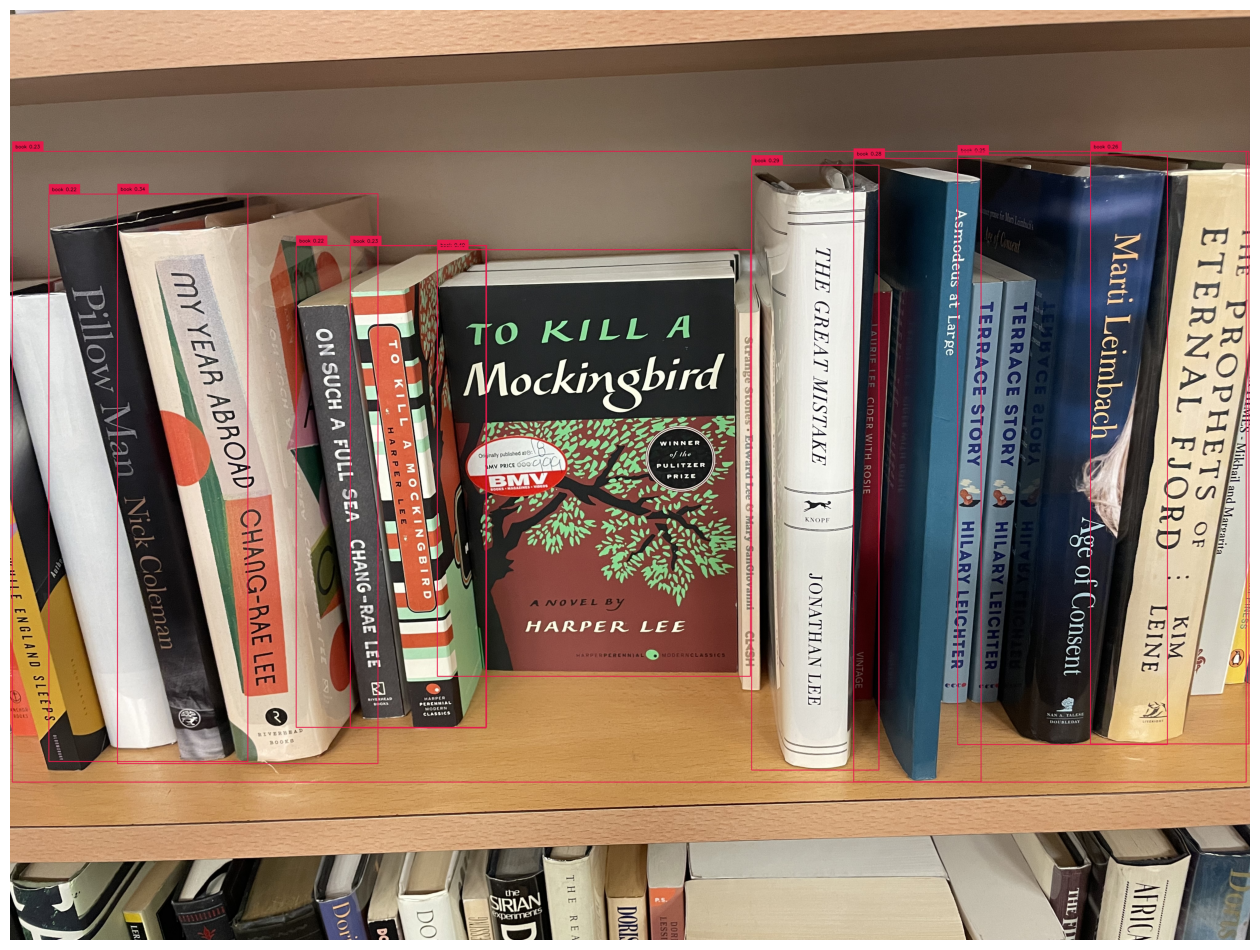

In [19]:
# Performing object detection using Grounding DINO
CLASSES = ['book']
BOX_TRESHOLD = 0.2
TEXT_TRESHOLD = 0.2

detections = dino.predict_with_classes(
    image=images[2],
    classes=CLASSES,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections]
annotated_frame = box_annotator.annotate(scene=images[2].copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [20]:
# Using the objects, perform segmentation using Segment Anything
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

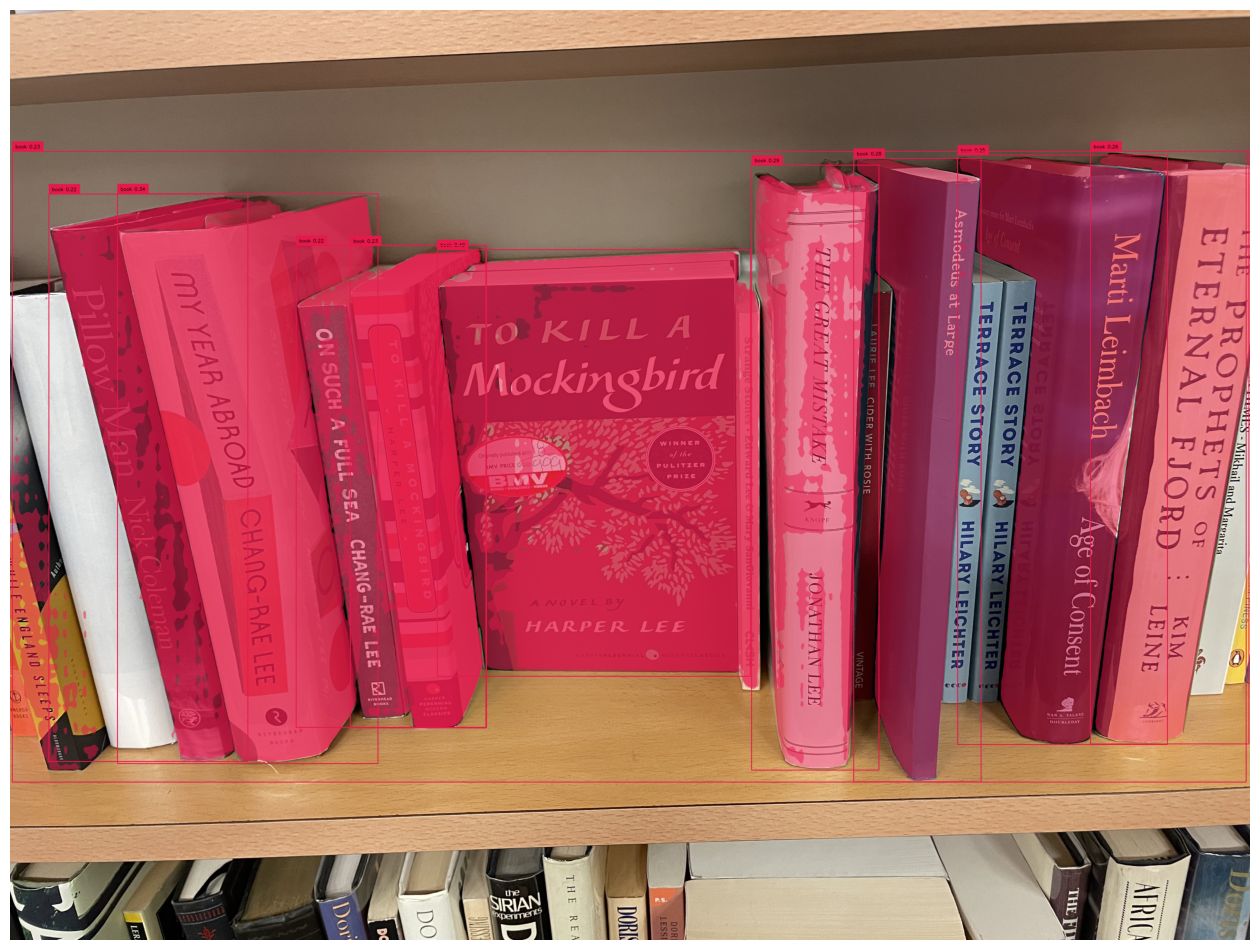

In [23]:
# convert detections to masks
detections.mask = segment(
    sam_predictor=sam,
    image=cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections]
annotated_image = mask_annotator.annotate(scene=images[2].copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))